In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

from anomaly.constants import GALAXY_LINES

In [2]:
# constants
balmer_lines = {
    "H-delta": 4101.734,
    "H-gamma": 4340.472,
    "H-beta": 4861.352,
    "H-alpha": 6562.787,
}

In [3]:
# directories for data
bin_id = "bin_03"
user = "/home/edgar"
work_directory = f"{user}/spectra/0_01_z_0_5_4_0_snr_inf"
model = "256_128_64/latent_12/"
metric = "mse_filter_250kms_noRel100"
# metric = "mse_filter_250kms_noRel97"
# metric = "mse_noRel97"
# metric = "mse_filter_250kms_rel100"
# metric = "mse_filter_250kms_rel97"
# metric = "mse_rel100"
# metric = "mse_rel97"
data_directory = f"{work_directory}/{bin_id}/" f"explanation/{model}/{metric}"

In [4]:
df_anomalies = pd.read_csv(
    f"{data_directory}/top_anomalies.csv.gz", index_col="specobjid"
)

wave = np.load(f"{work_directory}/wave_spectra_imputed.npy")
anomalies = np.load(f"{data_directory}/top_anomalies.npy")

# load the weights
explanation_weights = np.load(f"{data_directory}/weights_all_abs.npy")

In [5]:
explanation_weights.min(), explanation_weights.max()

(0.0, 1.0)

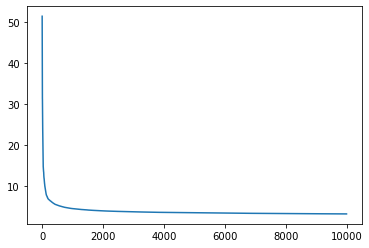

In [6]:
# sort scores in descending order in place in the df
df_anomalies.sort_values(by="score", ascending=False, inplace=True)
# reverse spectra in anomalies and weights array as well
anomalies = anomalies[::-1]

plt.plot(df_anomalies["score"].to_numpy())

## Clustering of weights for Balmer line

In [42]:
# Define the regions of interest around the Balmer lines
radious = 20

h_delta_region = (
    balmer_lines["H-delta"] - radious,
    balmer_lines["H-delta"] + radious,
)

h_gamma_region = (
    balmer_lines["H-gamma"] - radious,
    balmer_lines["H-gamma"] + radious,
)

h_beta_region = (
    balmer_lines["H-beta"] - radious,
    balmer_lines["H-beta"] + radious,
)

h_alpha_region = (
    balmer_lines["H-alpha"] - radious,
    balmer_lines["H-alpha"] + radious,
)

regions_of_interest = {
    "H-delta": h_delta_region,
    "H-gamma": h_gamma_region,
    "H-beta": h_beta_region,
    "H-alpha": h_alpha_region,
}

# Define a single mask for regions of interest in the wave array
balmer_mask = np.where(
    np.logical_or(
        np.logical_or(
            np.logical_and(
                wave >= h_delta_region[0], wave <= h_delta_region[1]
            ),
            np.logical_and(
                wave >= h_gamma_region[0], wave <= h_gamma_region[1]
            ),
        ),
        np.logical_or(
            np.logical_and(wave >= h_beta_region[0], wave <= h_beta_region[1]),
            np.logical_and(
                wave >= h_alpha_region[0], wave <= h_alpha_region[1]
            ),
        ),
    ),
    True,
    False,
)

h_delta_mask = np.where(
    np.logical_and(wave >= h_delta_region[0], wave <= h_delta_region[1]),
    True,
    False,
)

h_gamma_mask = np.where(
    np.logical_and(wave >= h_gamma_region[0], wave <= h_gamma_region[1]),
    True,
    False,
)

h_beta_mask = np.where(
    np.logical_and(wave >= h_beta_region[0], wave <= h_beta_region[1]),
    True,
    False,
)

h_alpha_mask = np.where(
    np.logical_and(wave >= h_alpha_region[0], wave <= h_alpha_region[1]),
    True,
    False,
)

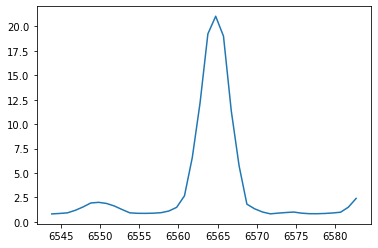

In [44]:
plt.plot(wave[h_alpha_mask], anomalies[100][h_alpha_mask])

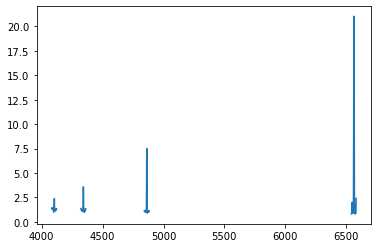

In [45]:
# plot a single spectrum with the mask of the regions of interest
spectrum = anomalies[100].copy()
spectrum[~balmer_mask] = np.nan
plt.plot(wave, spectrum)

In [46]:
# create a dictionary to store the weights of the balmer region
balmer_weights = explanation_weights[:, balmer_mask]
balmer_weights.shape, balmer_weights.min(), balmer_weights.max()

((10000, 160), 0.0, 1.0)

In [32]:
# # Create a list to store the evaluation metric values
# inertias = []
# n_clusters = range(2, 12)

# # Fit the k-means model with a range of values for the number of clusters

# for n in n_clusters:

#     kmeans = KMeans(n_clusters=n, random_state=0)

#     kmeans.fit(balmer_weights)
#     inertias.append(kmeans.inertia_)

#     print(f"n: {n}, inertia: {kmeans.inertia_}")

# # normalize the inertias
# inertias = np.array(inertias) / np.max(inertias)

# # Plot the evaluation metric values against the number of clusters
# plt.plot(n_clusters, inertias, '-o')
# plt.xlabel('Number of clusters')
# plt.ylabel('Inertia')
# plt.show()

In [56]:
# Use a k-means clustering for the balmer region

n_clusters = 10

kmeans = KMeans(n_clusters=n_clusters, random_state=0)

cluster_labels = kmeans.fit_predict(balmer_weights)

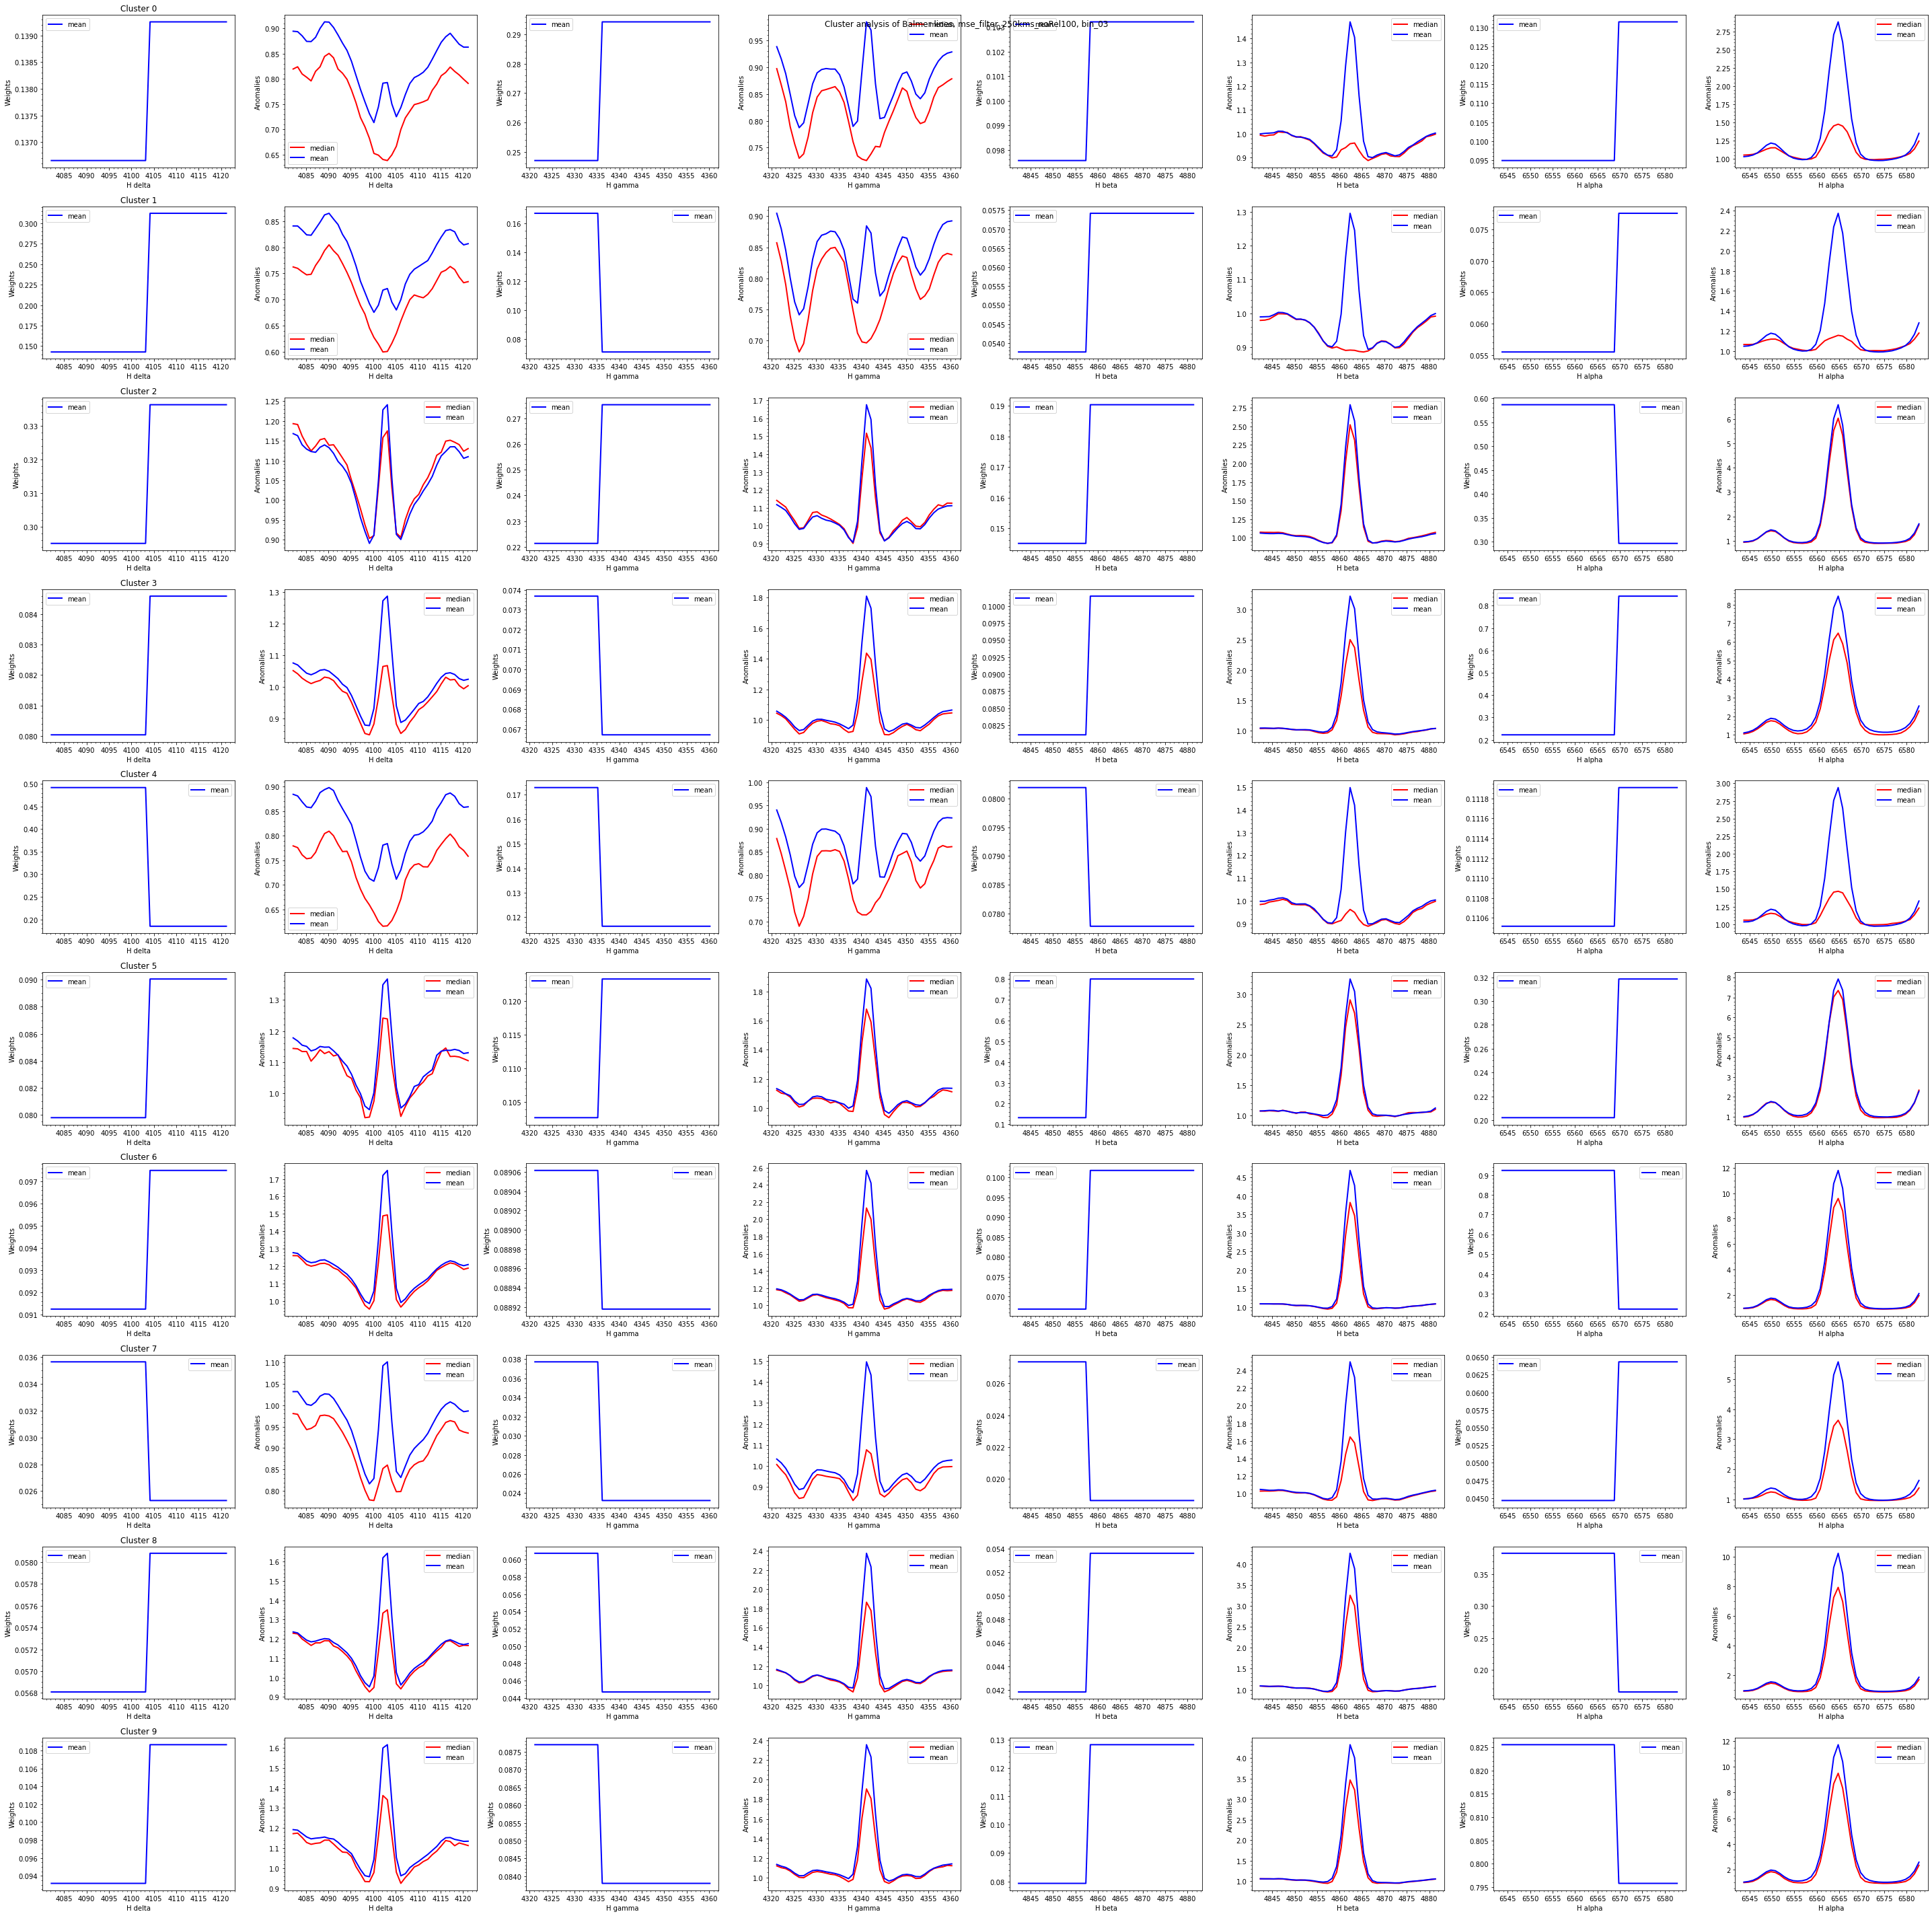

In [63]:
# Create a figure with a grid of subplots
n_subplots = 8
fig, axs = plt.subplots(
    kmeans.n_clusters,
    n_subplots,
    tight_layout=True,
    sharex=False,
    sharey=False,
    figsize=(40, 40),
)

# minor ticks on
for ax in axs.flat:
    ax.minorticks_on()

# Add a title to the figure
fig.suptitle(
    f"Cluster analysis of Balmer lines, {metric}, {bin_id}", fontsize=12
)

# Loop over the clusters
for cluster_n in range(kmeans.n_clusters):

    # Select the spectra in the cluster
    cluster_anomalies = anomalies[cluster_labels == cluster_n]
    # cluster_anomalies[:, ~balmer_mask] = np.nan

    cluster_weights = explanation_weights[cluster_labels == cluster_n]
    # cluster_weights[:, ~balmer_mask] = np.nan

    # Compute summary statistics for the explanations in the cluster
    cluster_median_weights = np.nanmedian(cluster_weights, axis=0)
    cluster_mean_weights = np.nanmean(cluster_weights, axis=0)
    cluster_std_weights = np.nanstd(cluster_weights, axis=0)

    # Compute summary statistics for the anomalies in the cluster

    cluster_median_anomalies = np.nanmedian(cluster_anomalies, axis=0)
    cluster_mean_anomalies = np.nanmean(cluster_anomalies, axis=0)
    cluster_std_anomalies = np.nanstd(cluster_anomalies, axis=0)

    # plot weights even columns and balmer lines in odd columns

    # axs[cluster_n, 0].plot(
    #     wave[h_delta_mask], cluster_median_weights[h_delta_mask], color="red", label="median", linewidth=2,
    # )
    axs[cluster_n, 0].plot(
        wave[h_delta_mask],
        cluster_mean_weights[h_delta_mask],
        color="blue",
        label="mean",
        linewidth=2,
    )

    axs[cluster_n, 1].plot(
        wave[h_delta_mask],
        cluster_median_anomalies[h_delta_mask],
        color="red",
        label="median",
        linewidth=2,
    )

    axs[cluster_n, 1].plot(
        wave[h_delta_mask],
        cluster_mean_anomalies[h_delta_mask],
        color="blue",
        label="mean",
        linewidth=2,
    )

    # axs[cluster_n, 2].plot(
    #     wave[h_gamma_mask], cluster_median_weights[h_gamma_mask], color="red", label="median", linewidth=2,
    # )
    axs[cluster_n, 2].plot(
        wave[h_gamma_mask],
        cluster_mean_weights[h_gamma_mask],
        color="blue",
        label="mean",
        linewidth=2,
    )

    axs[cluster_n, 3].plot(
        wave[h_gamma_mask],
        cluster_median_anomalies[h_gamma_mask],
        color="red",
        label="median",
        linewidth=2,
    )

    axs[cluster_n, 3].plot(
        wave[h_gamma_mask],
        cluster_mean_anomalies[h_gamma_mask],
        color="blue",
        label="mean",
        linewidth=2,
    )

    # axs[cluster_n, 4].plot(
    #     wave[h_beta_mask], cluster_median_weights[h_beta_mask], color="red", label="median", linewidth=2,
    # )
    axs[cluster_n, 4].plot(
        wave[h_beta_mask],
        cluster_mean_weights[h_beta_mask],
        color="blue",
        label="mean",
        linewidth=2,
    )

    axs[cluster_n, 5].plot(
        wave[h_beta_mask],
        cluster_median_anomalies[h_beta_mask],
        color="red",
        label="median",
        linewidth=2,
    )

    axs[cluster_n, 5].plot(
        wave[h_beta_mask],
        cluster_mean_anomalies[h_beta_mask],
        color="blue",
        label="mean",
        linewidth=2,
    )

    # axs[cluster_n, 6].plot(
    #     wave[h_alpha_mask], cluster_median_weights[h_alpha_mask], color="red", label="median", linewidth=2,
    # )

    axs[cluster_n, 6].plot(
        wave[h_alpha_mask],
        cluster_mean_weights[h_alpha_mask],
        color="blue",
        label="mean",
        linewidth=2,
    )

    axs[cluster_n, 7].plot(
        wave[h_alpha_mask],
        cluster_median_anomalies[h_alpha_mask],
        color="red",
        label="median",
        linewidth=2,
    )

    axs[cluster_n, 7].plot(
        wave[h_alpha_mask],
        cluster_mean_anomalies[h_alpha_mask],
        color="blue",
        label="mean",
        linewidth=2,
    )

    axs[cluster_n, 0].set_title(f"Cluster {cluster_n}")
    axs[cluster_n, 0].set_ylabel("Weights")
    axs[cluster_n, 1].set_ylabel("Anomalies")
    axs[cluster_n, 2].set_ylabel("Weights")
    axs[cluster_n, 3].set_ylabel("Anomalies")
    axs[cluster_n, 4].set_ylabel("Weights")
    axs[cluster_n, 5].set_ylabel("Anomalies")
    axs[cluster_n, 6].set_ylabel("Weights")
    axs[cluster_n, 7].set_ylabel("Anomalies")

    axs[cluster_n, 0].set_xlabel("H delta")
    axs[cluster_n, 1].set_xlabel("H delta")
    axs[cluster_n, 2].set_xlabel("H gamma")
    axs[cluster_n, 3].set_xlabel("H gamma")
    axs[cluster_n, 4].set_xlabel("H beta")
    axs[cluster_n, 5].set_xlabel("H beta")
    axs[cluster_n, 6].set_xlabel("H alpha")
    axs[cluster_n, 7].set_xlabel("H alpha")

    axs[cluster_n, 0].legend()
    axs[cluster_n, 1].legend()
    axs[cluster_n, 2].legend()
    axs[cluster_n, 3].legend()
    axs[cluster_n, 4].legend()
    axs[cluster_n, 5].legend()
    axs[cluster_n, 6].legend()
    axs[cluster_n, 7].legend()

# save the figure in data_directory in pdf format

fig.savefig(f"{data_directory}/balmer_weights_clustering_{n_clusters}.pdf")

In [60]:
data_directory

'/home/edgar/spectra/0_01_z_0_5_4_0_snr_inf/bin_03/explanation/256_128_64/latent_12//mse_filter_250kms_noRel100'